# Exploration

We plot the dimension of activity and compare to to reciprocal density (measured as rc_over_nodes).  The data was precomputed using `../code/compute_activity_dimension.py`

In [2]:
# General 
import numpy as np
import pandas as pd
from scipy import stats
# Connectomes and network analysis
import conntility
from connalysis.network import local 
from connalysis.network import stats as nstats

# Plotting
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
# Specific to this project
import sys 
sys.path.append('../../../library')
from preprocess import load_spike_trains, extract_binned_spike_signals
from dimensionality import get_spectrum_nbds, get_dimensions_nbds, get_dimensions

### Get data 

In [3]:
# Get connectome 
root="/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/"
fname=f"{root}working_dir/connectome.h5"
conn=conntility.ConnectivityMatrix.from_h5(fname).index("synapse_class").isin("EXC")
# Load structural properties of neighborhoods
props=pd.read_pickle('/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/props_BBP_original.pkl')
props["layer"]=conn.vertices["layer"]
props["gid"]=conn.vertices["index"]
# Get top and bottom complexity neighborhoods
thresh=0.01; base_prop="rc_over_nodes"
q=props.quantile(q=0.01)
Q=props.quantile(q=1-0.01)
props['tribe_sparsity_nodes']=np.nan
# Sparse ones
props['tribe_sparsity_nodes'][(props[base_prop]<=q[base_prop])]='low complexity'
# Dense ones
props['tribe_sparsity_nodes'][(props[base_prop]>=Q[base_prop])]='high complexity'
# Load efficiency data
dims=pd.read_pickle("/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_signals.pkl")
#dims=pd.read_pickle("/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/Toposample_O1v5-SONATA/working_dir/dimensions_EE_from_spikes.pkl")
props=pd.concat([props, dims],axis=1)
props['normalized_dim']=(props['actitivy_dimension']/props['active_ts']).astype(float)
# Reliability data
fname="/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/simulations/BlobStimReliability_O1v5-SONATA_Baseline"
rel_path=f'{fname}/working_dir/reliability_basic.npz'
props["reliability"]=np.load(rel_path)['reliability']

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/1452025472.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  props['tribe_sparsity_nodes'][(props[base_prop]<=q[base_prop])]='low complexity'


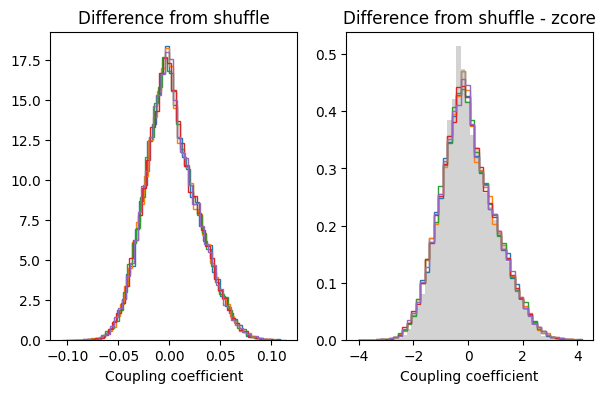

In [4]:
# Soloist data 
cc_filename = "/gpfs/bbp.cscs.ch/data/scratch/proj9/bisimplices/bbp_workflow/7b381e96-91ac-4ddd-887b-1f563872bd1c/working_dir/coupling_coefficients.h5"
cc = pd.read_hdf(cc_filename, key="CC_bin_sz_2p0")
diff=pd.DataFrame() # Difference from shuffle 
for i, col in enumerate(cc.columns[:-1]):
    diff[f"Control_{i}"]=cc["data"]-cc[col]
fig, axs = plt.subplots(1,2, figsize = (7,4))
for i in range(5): 
    axs[0].hist(diff[f"Control_{i}"], histtype="step", density=True, bins=50)
    axs[0].set_title("Difference from shuffle")
    axs[0].set_xlabel("Coupling coefficient") 
for i in range(5): 
    bins =50 if i==0 else bins
    _,bins,_=axs[1].hist(stats.zscore(diff[f"Control_{i}"], axis=0), histtype="step", density=True, bins=bins)
    axs[1].set_title("Difference from shuffle - zcore")
    axs[1].set_xlabel("Coupling coefficient") 
# Add to props 
props.set_index("gid", inplace=True)
props["Coupling_coefficient"]=stats.zscore(diff).mean(axis=1)
_=plt.hist(props["Coupling_coefficient"], bins=bins, color="lightgrey", density=True)

In [5]:
# Selecting soloist and choristers from the tails 
x=props["Coupling_coefficient"]
x=x[~np.isnan(x)]
print(f"CC threshold for 1% bottom:{np.quantile(x, .01)}, top:{np.quantile(x, .99)}")
props["Soloist"]=(props["Coupling_coefficient"]<np.quantile(x, .01))
props["Chorister"]=(props["Coupling_coefficient"]>np.quantile(x, .99))
# Computing values across neighborhoods 
neighborhoods=local.neighborhood_indices(conn.matrix)
print("Done computing nbds")
values=props["Soloist"].reset_index(drop=True)
sol_stats=nstats.node_stats_neighborhood(values,precomputed=True,neighborhoods=neighborhoods)
print("Done with soloist stats")
values=props["Chorister"].reset_index(drop=True)
chor_stats=nstats.node_stats_neighborhood(values,precomputed=True,neighborhoods=neighborhoods)
print("Done with chorister stats")
values=props["reliability"].reset_index(drop=True)
nbd_rel=nstats.node_stats_neighborhood(values,precomputed=True,neighborhoods=neighborhoods)
print("Done with reliability stats")
values=props["Coupling_coefficient"].reset_index(drop=True)
nbd_cc=nstats.node_stats_neighborhood(values,precomputed=True,neighborhoods=neighborhoods)
print("Done with CC stats")
# Add to DF 
props["nbd_reliability"]=nbd_rel["mean"].to_numpy()
props["soloist_count"]=sol_stats["sum"].to_numpy()
props["soloist_frac"]=sol_stats["mean"].to_numpy()
props["chorister_count"]=chor_stats["sum"].to_numpy()
props["chorister_frac"]=chor_stats["mean"].to_numpy()
props["nbd_Coupling_coefficient"]=nbd_cc["mean"].to_numpy()

CC threshold for 1% bottom:-1.950013835159747, top:2.3825944427618584
Done computing nbds
Done with soloist stats
Done with chorister stats
Done with reliability stats
Done with CC stats


In [6]:
# Restricting to structured and unstructured
data=props[np.logical_or(props["tribe_sparsity_nodes"]=="high complexity", props["tribe_sparsity_nodes"]=="low complexity")]
data["dummy"]=1

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/530932090.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["dummy"]=1


# Plotting

In [7]:
# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=6
conversion=2.54
#conversion=1.5

marker_size=2
linewidth=2; linewidth_base=1; linestyle_base="dotted"; alpha_base=0.75

# Setting up colors 
colors={
    'high complexity': 'tab:purple', 
    'low complexity': 'tab:cyan', 
    2:matplotlib.colormaps["Set3"](0),
    3:matplotlib.colormaps["Set3"](2),
    4:matplotlib.colormaps["Set3"](5),
    5:matplotlib.colormaps["Set3"](4),
    6:matplotlib.colormaps["Set3"](3)
}
cmaps={}
for key in ['high complexity', 'low complexity']:
    n_bin =  5  # Number of bins to discretizes the interpolation into
    cmap_name = key
    cmaps[key] = LinearSegmentedColormap.from_list(key, ["white", colors[key]], N=n_bin)

In [8]:
def scatter_and_regress(ax, data, x_col, y_col, color, marker='o', marker_size=marker_size, label=None, color_regress=None):
    x=data[x_col]; y=data[y_col] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    if color_regress is None: color_regress=color
    ax.plot(x, x*regress.slope+regress.intercept, color=color_regress, label=f"{regress.rvalue:.2f}")
    ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )
    h, l = ax.get_legend_handles_labels()
    return ax, h, l
    
def plot_relation(ax, y,x=base_prop, add_inset=True, marker_size=marker_size):
    for layer in np.arange(5)+2:
        ax, h, l=scatter_and_regress(ax, props[props["layer"]==layer], x, y, color=colors[layer], marker='o', 
                                    marker_size=marker_size, label=str(layer)) #add alpha
    ax.spines[["right", "top"]].set_visible(False)
    if add_inset:
        left, bottomm, width, height = [0.7, 0.7, 0.3, 0.3]
        ax_inset=ax.inset_axes([left, bottomm, width, height])
        sns.violinplot(data=data, x="dummy", y=y, ax=ax_inset,
                       hue="tribe_sparsity_nodes", split=True, inner="quart", palette=colors,linewidth=0.001)
        ax_inset.get_legend().remove()
        ax_inset.spines[["left", "top", "bottom"]].set_visible(False)
        ax_inset.yaxis.set_ticks_position("right")
        #ax_inset.set_yticks([0.6, 0.9],labels=[0.6, 0.9], fontsize=ticksize)
        ax_inset.set_xticks([])
        ax_inset.set_xlabel('')
        ax_inset.set_ylabel('')
    else:
        ax_inset=None
    return h, l, ax_inset

(array([  47.,  384., 1506., 3538., 5178., 5998., 5077., 3297., 1396.,
         146.]),
 array([-0.78620641, -0.61037407, -0.43454174, -0.2587094 , -0.08287706,
         0.09295527,  0.26878761,  0.44461995,  0.62045228,  0.79628462,
         0.97211696]),
 <BarContainer object of 10 artists>)

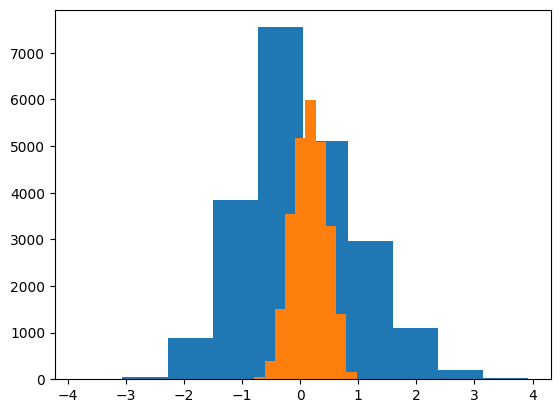

In [9]:
plt.hist(props["Coupling_coefficient"])
plt.hist(props["nbd_Coupling_coefficient"])

In [10]:
props.columns

Index(['nbd_size', 'edges', 'rc_over_nodes', 'rc_over_edges', 'density',
       'degree_skewness', 'euclidean_nodes_sc', 'euclidean_edges_sc',
       'cosine_sc', 'wasserstein_deg_total', 'wasserstein_deg_IN',
       'wasserstein_deg_OUT', 'layer', 'tribe_sparsity_nodes',
       'actitivy_dimension', 'active_ts', 'ts', 'normalized_dim',
       'reliability', 'Coupling_coefficient', 'Soloist', 'Chorister',
       'nbd_reliability', 'soloist_count', 'soloist_frac', 'chorister_count',
       'chorister_frac', 'nbd_Coupling_coefficient'],
      dtype='object')

Text(0, 0.5, 'wasserstein_deg_total')

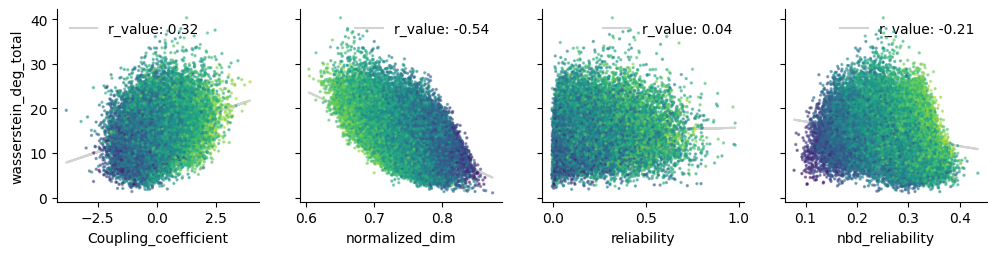

In [11]:
y="wasserstein_deg_total"
c_vals="nbd_Coupling_coefficient"
fig, axs = plt.subplots(1,4,figsize=(12,2.5),sharey=True)


for i, x in enumerate(["Coupling_coefficient", "normalized_dim", "reliability", "nbd_reliability"]):
    axs[i], h, l = scatter_and_regress(axs[i], props, x, y, 
                                             color=props[c_vals], 
                                            color_regress="lightgray")
    axs[i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[i].spines[["top", "right"]].set_visible(False)
    axs[i].set_xlabel(x)
    

axs[0].set_ylabel(y)
    


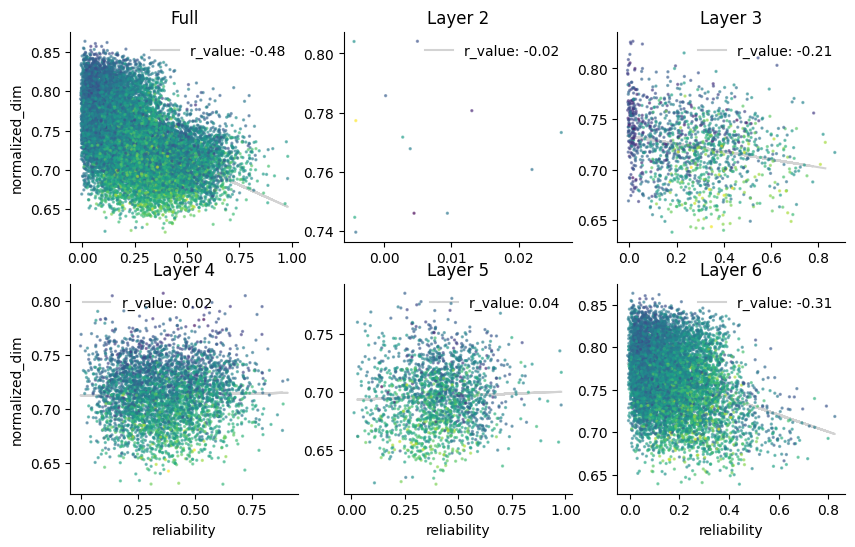

In [12]:
y="normalized_dim"
x="reliability"
c_vals="Coupling_coefficient"
fig, axs = plt.subplots(2,3,figsize=(10,6)) 
axs[0,0], h, l = scatter_and_regress(axs[0,0], props, x, y, 
                                         color=props[c_vals], 
                                        color_regress="lightgray")
axs[0,0].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
axs[0,0].set_title("Full")

for l in np.arange(5)+2:
    i=(l-1)//3;j=(l-1)%3
    axs[i,j].set_title(f"Layer {l}")
    axs[i,j], h, l = scatter_and_regress(axs[i,j], props.query(f"layer=={l}"), x, y, 
                                         color=props.query(f"layer=={l}")[c_vals], 
                                        color_regress="lightgray")
    axs[i,j].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)

for ax in axs.flatten(): 
    ax.spines[["top", "right"]].set_visible(False)
    
for ax in axs[:,0].flatten():
    ax.set_ylabel(y)
for ax in axs[1,:].flatten():
    ax.set_xlabel(x)


Text(0, 0.5, 'Normalized dimension')

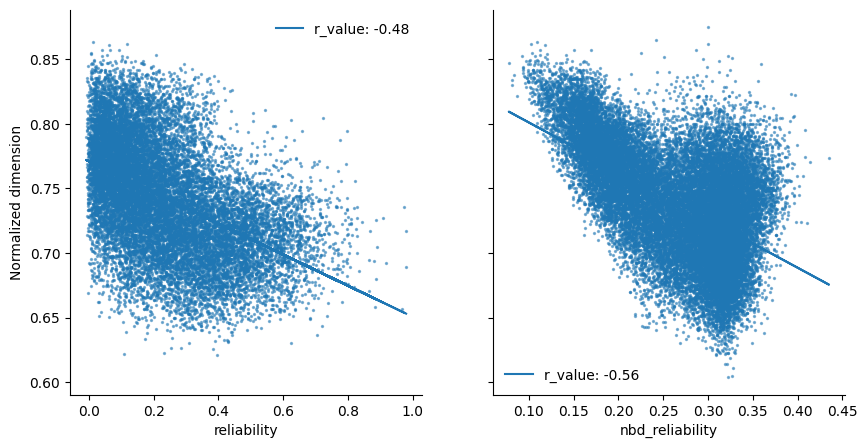

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True)
for i, feature in enumerate([ "reliability", "nbd_reliability"]):
    axs[i], h, l = scatter_and_regress(axs[i], props, feature, "normalized_dim", "C0")
    axs[i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[i].spines[["top", "right"]].set_visible(False) 
    axs[i].set_xlabel(f"{feature}")
axs[0].set_ylabel("Normalized dimension")

In [14]:
props.columns

Index(['nbd_size', 'edges', 'rc_over_nodes', 'rc_over_edges', 'density',
       'degree_skewness', 'euclidean_nodes_sc', 'euclidean_edges_sc',
       'cosine_sc', 'wasserstein_deg_total', 'wasserstein_deg_IN',
       'wasserstein_deg_OUT', 'layer', 'tribe_sparsity_nodes',
       'actitivy_dimension', 'active_ts', 'ts', 'normalized_dim',
       'reliability', 'Coupling_coefficient', 'Soloist', 'Chorister',
       'nbd_reliability', 'soloist_count', 'soloist_frac', 'chorister_count',
       'chorister_frac', 'nbd_Coupling_coefficient'],
      dtype='object')

Text(0, 0.5, 'wasserstein_deg_total')

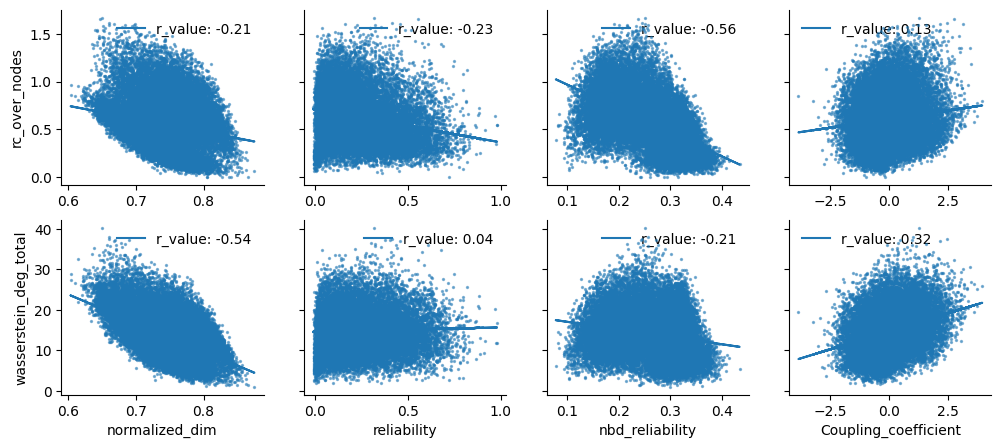

In [15]:
fig, axs = plt.subplots(2, 4, figsize=(12,5), sharey='row')
for i, feature in enumerate(["normalized_dim", "reliability", "nbd_reliability","Coupling_coefficient"]):
    axs[0,i], h, l = scatter_and_regress(axs[0,i], props, feature, "rc_over_nodes", "C0")
    axs[0,i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[1,i], h, l = scatter_and_regress(axs[1,i], props, feature, "wasserstein_deg_total", "C0")
    axs[1,i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[0,i].spines[["top", "right"]].set_visible(False) 
    axs[1,i].spines[["top", "right"]].set_visible(False) 
    axs[1,i].set_xlabel(f"{feature}")
axs[0,0].set_ylabel("rc_over_nodes")
axs[1,0].set_ylabel("wasserstein_deg_total")

Text(0, 0.5, 'Nbd coupling coefficient')

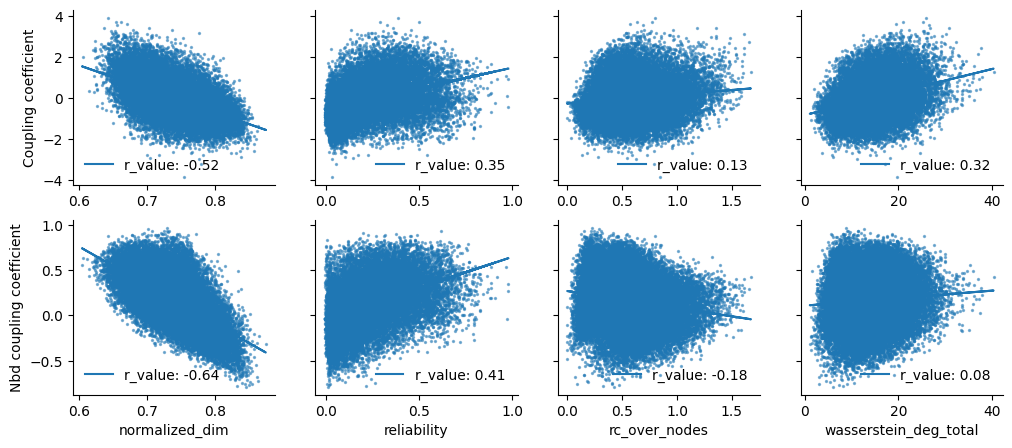

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(12,5), sharey='row')
for i, feature in enumerate(["normalized_dim", "reliability", "rc_over_nodes", "wasserstein_deg_total"]):
    axs[0,i], h, l = scatter_and_regress(axs[0,i], props, feature, "Coupling_coefficient", "C0")
    axs[0,i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[1,i], h, l = scatter_and_regress(axs[1,i], props, feature, "nbd_Coupling_coefficient", "C0")
    axs[1,i].legend([h[0]], [f"r_value: {l[0]}"], frameon=False)
    axs[0,i].spines[["top", "right"]].set_visible(False) 
    axs[1,i].spines[["top", "right"]].set_visible(False) 
    axs[1,i].set_xlabel(f"{feature}")
axs[0,0].set_ylabel("Coupling coefficient")
axs[1,0].set_ylabel("Nbd coupling coefficient")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/4202187140.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )


Text(0, 0.5, 'Coupling coefficient')

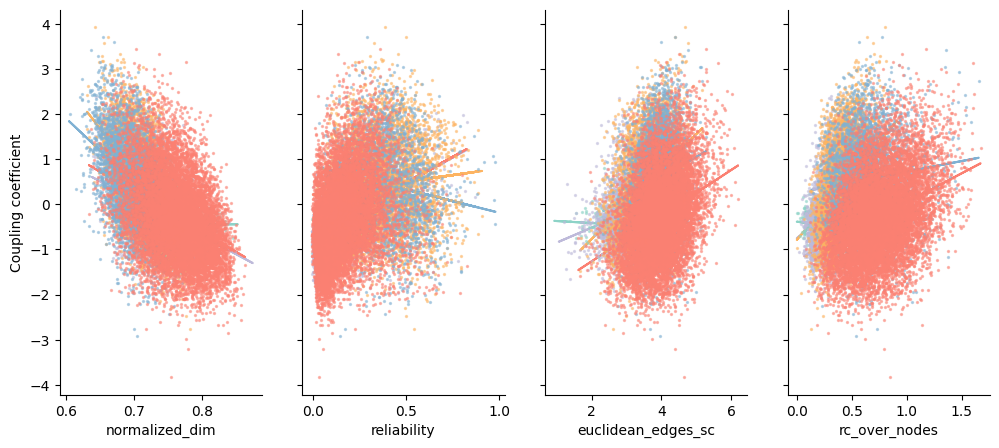

In [17]:
fig, axs = plt.subplots(1, 4, figsize=(12,5), sharey=True)
for i, feature in enumerate(["normalized_dim", "reliability", "euclidean_edges_sc", "rc_over_nodes"]):
    h_reg, l_reg, ax_inset =plot_relation(axs[i], "Coupling_coefficient",x=feature, add_inset=False)#, marker_size=marker_size)
    axs[i].set_xlabel(f"{feature}")
axs[0].set_ylabel("Coupling coefficient")

In [18]:
def plot_violin(ax, y):
    sns.violinplot(data=data, x="dummy", y=y, ax=ax,
                   hue="tribe_sparsity_nodes", split=True, inner="quart", palette=colors)#,linewidth=0.001)
    ax.spines[["right", "top", "bottom"]].set_visible(False)
    #ax.yaxis.set_ticks_position("right")
    #ax.set_yticks([0.6, 0.9],labels=[0.6, 0.9], fontsize=ticksize)
    ax.set_xticks([])
    ax.set_xlabel('')
    #ax.set_ylabel('')'''
    return ax

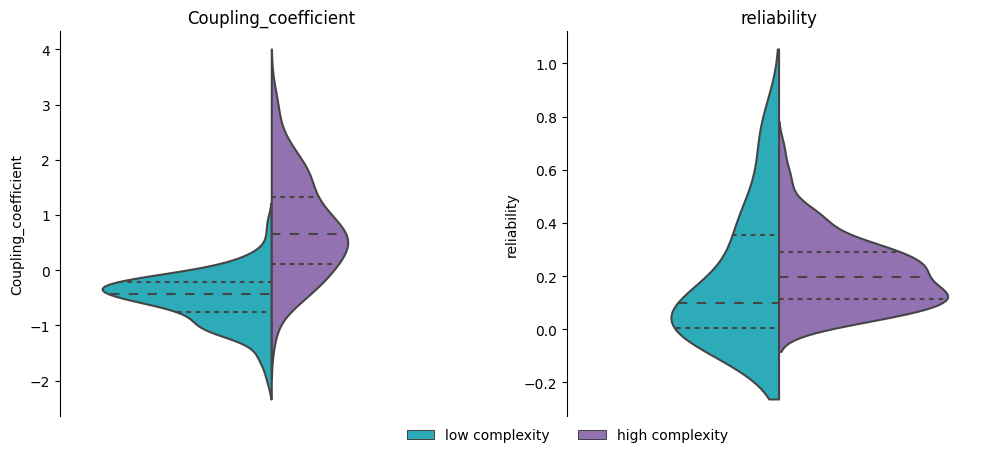

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=False)
for i, feature in enumerate(["Coupling_coefficient", "reliability"]):
    axs[i]=plot_violin(axs[i], y=feature)
    axs[i].set_title(f"{feature}")
    if i!=1:
        axs[i].get_legend().remove()
axs[1].legend(frameon=False,ncol=2, loc="lower center", bbox_to_anchor=(0,-0.1))


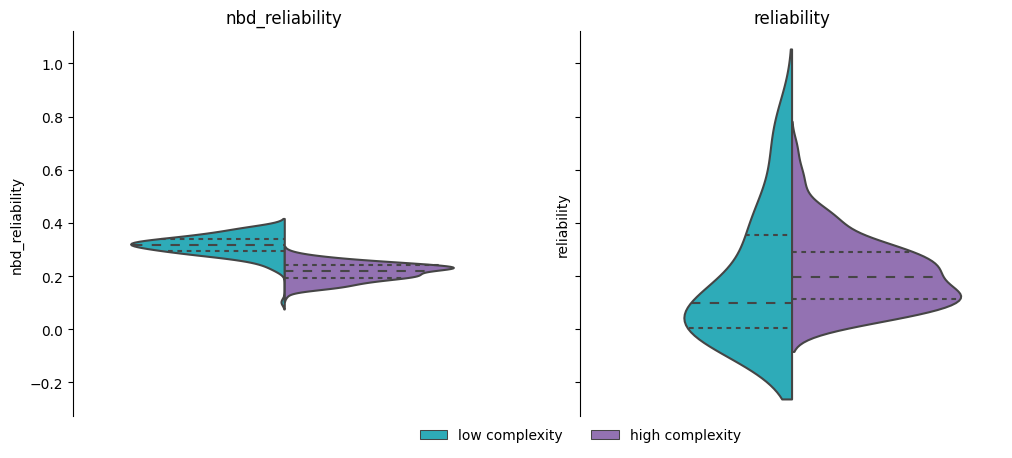

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), sharey=True)
for i, feature in enumerate(["nbd_reliability", "reliability"]):
    axs[i]=plot_violin(axs[i], y=feature)
    axs[i].set_title(f"{feature}")
    if i!=1:
        axs[i].get_legend().remove()
axs[1].legend(frameon=False,ncol=2, loc="lower center", bbox_to_anchor=(0,-0.1))


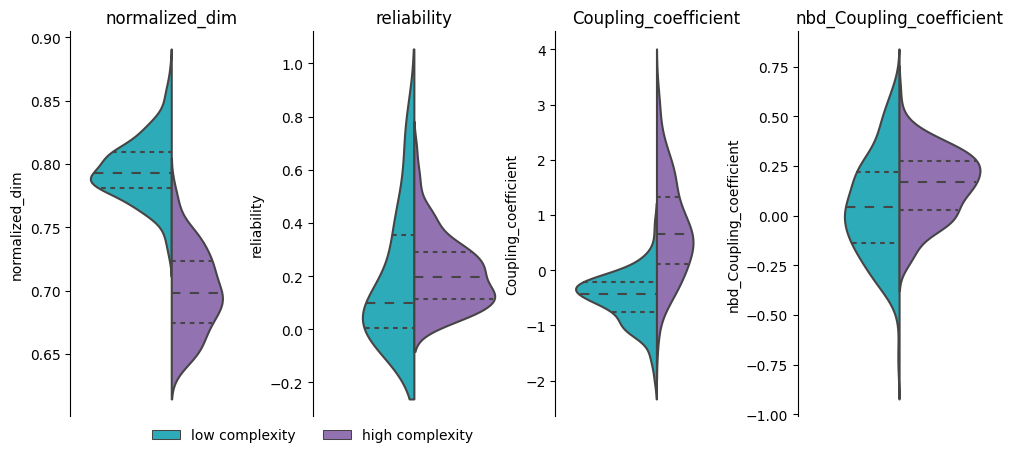

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(12,5), sharey=False)
for i, feature in enumerate(["normalized_dim", "reliability", "Coupling_coefficient", "nbd_Coupling_coefficient"]):
    axs[i]=plot_violin(axs[i], y=feature)
    axs[i].set_title(f"{feature}")
    if i!=1:
        axs[i].get_legend().remove()
axs[1].legend(frameon=False,ncol=2, loc="lower center", bbox_to_anchor=(0,-0.1))


/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/4202187140.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )


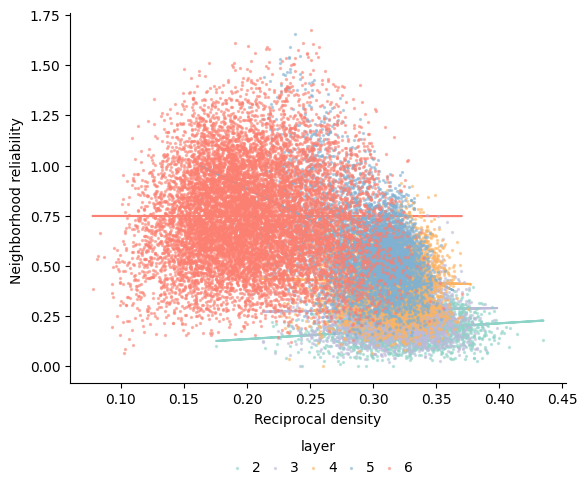

In [22]:
fig, axs = plt.subplots()
h_reg, l_reg, ax_inset =plot_relation(axs, "rc_over_nodes",x="nbd_reliability", add_inset=False)#, marker_size=marker_size)
axs.set_xlabel("Reciprocal density")
axs.set_ylabel("Neighborhood reliability ")
axs.legend(h_reg[1::2], l_reg[1::2], frameon=False, ncols=5, #fontsize=labelsize, 
           title="layer", #title_fontsize=labelsize,
           columnspacing = .001, handletextpad=0.1,
           bbox_to_anchor=(0.4, -0.25, 0.2, 0.1), loc="center")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/4202187140.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )


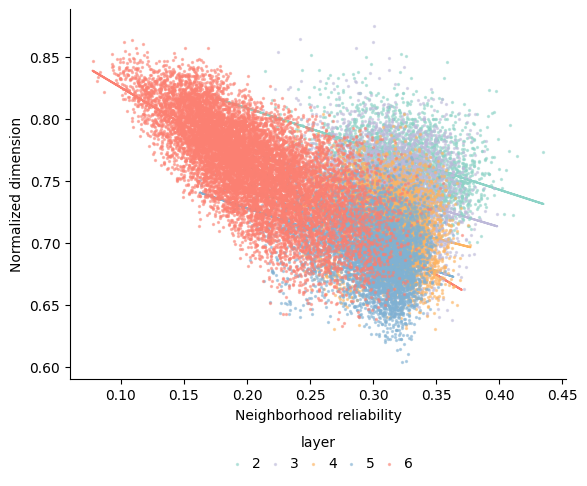

In [23]:
fig, axs = plt.subplots()
h_reg, l_reg, ax_inset =plot_relation(axs, "normalized_dim",x="nbd_reliability", add_inset=False)#, marker_size=marker_size)
axs.set_xlabel("Neighborhood reliability")
axs.set_ylabel("Normalized dimension")
axs.legend(h_reg[1::2], l_reg[1::2], frameon=False, ncols=5, #fontsize=labelsize, 
           title="layer", #title_fontsize=labelsize,
           columnspacing = .001, handletextpad=0.1,
           bbox_to_anchor=(0.4, -0.25, 0.2, 0.1), loc="center")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/4202187140.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )


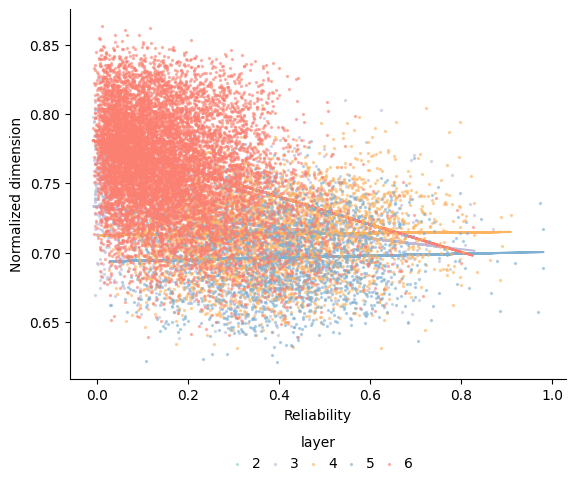

In [24]:
fig, axs = plt.subplots()
h_reg, l_reg, ax_inset =plot_relation(axs, "normalized_dim",x="reliability", add_inset=False)#, marker_size=marker_size)
axs.set_xlabel("Reliability")
axs.set_ylabel("Normalized dimension")
axs.legend(h_reg[1::2], l_reg[1::2], frameon=False, ncols=5, #fontsize=labelsize, 
           title="layer", #title_fontsize=labelsize,
           columnspacing = .001, handletextpad=0.1,
           bbox_to_anchor=(0.4, -0.25, 0.2, 0.1), loc="center")

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/egassant/1999031/ipykernel_205948/4202187140.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, c=color, marker=marker,s=marker_size, label=f"{label}",alpha=0.5, zorder=10, rasterized=True )


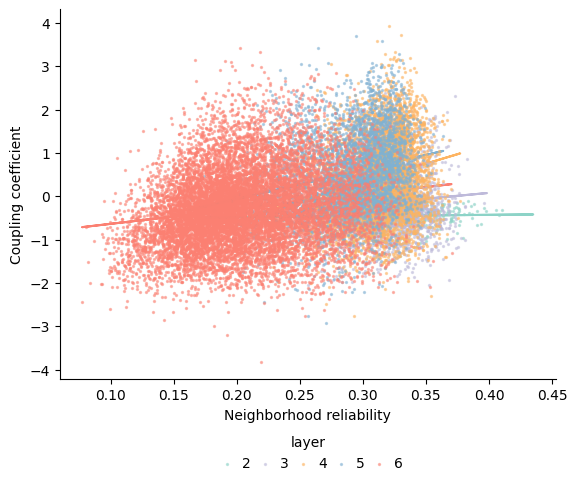

In [25]:
fig, axs = plt.subplots()
h_reg, l_reg, ax_inset =plot_relation(axs, "Coupling_coefficient",x="nbd_reliability", add_inset=False)#, marker_size=marker_size)
axs.set_xlabel("Neighborhood reliability")
axs.set_ylabel("Coupling coefficient")
axs.legend(h_reg[1::2], l_reg[1::2], frameon=False, ncols=5, #fontsize=labelsize, 
           title="layer", #title_fontsize=labelsize,
           columnspacing = .001, handletextpad=0.1,
           bbox_to_anchor=(0.4, -0.25, 0.2, 0.1), loc="center")

# Coupling and simplices? 

In [26]:
sys.path.append('../../../library')
from structural_basic import *
# Load connectivity data 
conn="BBP"
connectome=load_connectome("../../data", conn)

In [34]:
# Average across simplices filtering by layers (this is quick so we compute on the fly)  
#layers=['234', 5, 6]
layers=['23', '234', '4', '5','6', '56' ]
layer_dict={'23':[2,3], 
            '234':[2,3,4], 
            '4':[4], 
            '5':[5],
            '6':[6], 
            '56':[5,6]}
#layers=[6]
#stats_activity_per_layer={layer:{"all":{conn:{}}, "maximal":{conn:{}}} for layer in layers}
stats_activity_per_layer={layer:{"maximal":{conn:{}}} for layer in layers}
for stype in ["maximal"]: 
    # Load precomputed structural properties 
    if stype =="all":
                s_lists=pd.read_pickle(f"../../data/{conn}_list_simplices_by_dimension_.pkl")['original']
    elif stype =="maximal":
         s_lists=pd.read_pickle(f"../../data/{conn}_list_simplices_by_dimension_maximal.pkl")['original'] 
    # Average dimensionality
    for activity_param in ["CC", "reliability"]: 
        for layer in layers:
            if activity_param=="CC":
                vals=props["Coupling_coefficient"].reset_index(drop=True)
            elif activity_param=="reliability":
                vals=props["reliability"].reset_index(drop=True)
            # Filter by layer group
            mask=connectome.vertices.layer.isin(layer_dict[layer]).to_numpy()
            vals[~mask]=np.nan
            stats_activity_per_layer[layer][stype][conn][activity_param]=nstats.node_stats_per_position(s_lists,
                                                                                                        vals,
                                                                                                        dims=s_lists.index.drop(0),
                                                                                                        with_multiplicity=True)

 67%|██████████████████████████████               | 4/6 [00:29<00:15,  7.76s/it]/gpfs/bbp.cscs.ch/home/egassant/connalysis/lib/python3.10/site-packages/connalysis/network/stats.py:47: RuntimeWarning: Mean of empty slice
  stats_vals["mean"] = np.nanmean(vals_sl, axis=0)
/gpfs/bbp.cscs.ch/home/egassant/connalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
 67%|██████████████████████████████               | 4/6 [00:28<00:15,  7.68s/it]/gpfs/bbp.cscs.ch/home/egassant/connalysis/lib/python3.10/site-packages/connalysis/network/stats.py:47: RuntimeWarning: Mean of empty slice
  stats_vals["mean"] = np.nanmean(vals_sl, axis=0)
/gpfs/bbp.cscs.ch/home/egassant/connalysis/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|███████████████████

In [39]:
# Reformat data
def agg_along_dims(stats_dict, stype, conn, prop): 
    dims=[1, 2, 3, 4, 5, 6]
    df={"all":{}, "sink":{}, "source":{}}
    for dim in dims: 
        mean=stats_dict[stype][conn][prop][dim]["mean"]
        err=stats_dict[stype][conn][prop][dim]["sem"]
        df['all'][dim]=[mean.loc["all"], err.loc["all"]]
        df['source'][dim]=[mean.iloc[0], err.iloc[0]]
        df['sink'][dim]=[mean.iloc[-2], err.iloc[-2]]
    
    df={key:pd.DataFrame.from_dict(df[key], orient="index", columns=["mean", "sem"]) 
                                for key in df.keys()}
    return df
stats_BBP_per_layer={layer:{"maximal":{}} for layer in layers}
for stype in ["maximal"]: 
    for prop in ["CC", "reliability"]:
        for layer in layers:
            stats_BBP_per_layer[layer][stype][prop]=agg_along_dims(stats_activity_per_layer[layer], stype, conn, prop) 
   

In [36]:
def plot_and_fill(ax, data, label, color, ms, marker, alpha): 
    ax.plot(df["mean"], marker=marker, label=label, ms=ms)
    ax.fill_between(data.index, data["mean"]-data["sem"], data["mean"]+data["sem"], alpha=alpha)

# Figure settings and color schemes 
titlesize=8
labelsize=6
ticksize=4
conversion=2.54
#conversion=1.5
linewidth=2; 

colors={"all":"C0",
       "sink": "C1",
       "source":"C2"}
markers={"all":"o",
       "sink": ">",
       "source":"<"}
ms=2
alpha=0.25

Text(0.5, 1.1, 'BBP')

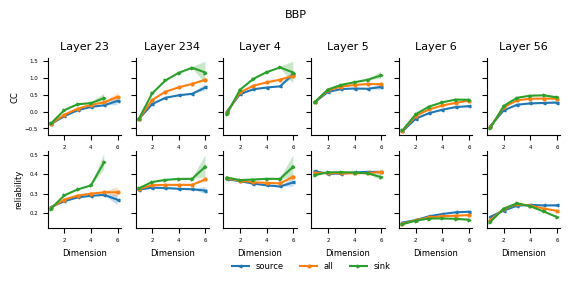

In [52]:
width=21*0.8/conversion

rows=2; cols=6
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows/cols), sharex=False, sharey="row")
# Efficiency and reliability across simplices 
stype="maximal" #"all"
for j, l in enumerate(layers):
    axs[0,j].set_title(f"Layer {l}", fontsize=titlesize)
    for i, prop in enumerate(["CC", "reliability"]):
        for pos in ["source", "all", "sink"]:  
            df=stats_BBP_per_layer[l][stype][prop][pos]
            plot_and_fill(axs[i,j], df, pos, colors[pos], ms, markers[pos], alpha=alpha)
            
        axs[i,j].spines[["top", "right"]].set_visible(False)
        axs[i,0].set_ylabel(prop, fontsize=labelsize)
        axs[1,j].set_xlabel("Dimension", fontsize=labelsize)

axs[1,3].legend(frameon=False, fontsize=labelsize, ncol=3,loc=8, bbox_to_anchor=(0,-0.65) )
#fig.savefig(f"temp_figs/efficiency_reliab_dimension_layer_{l}.pdf", transparent=True, bbox_inches="tight")

for ax in axs.flatten(): 
    ax.tick_params(axis='both', labelsize=ticksize)
plt.suptitle("BBP", fontsize=titlesize,y=1.1)
